# 1. Sequence fetching, Li et al.
___
Dr. Raffael lab <br>
2024

In [2]:
from pathlib import Path
import time

import matplotlib.pyplot as pl
from Bio import SeqIO
from tqdm import tqdm
import pandas as pd
import numpy as np
import ast

import multiprocessing as mp
from subprocess import PIPE
import subprocess
import copy

## Description

### 1. Prepare the Li et al. organism list by pre-processing and chunking

In [2]:
liOrgListPath = 'Lietal_OrgTempList/temperature_data_full.tsv'

temped_Li_list = pd.read_csv(liOrgListPath, delimiter = '\t').drop_duplicates()
print(len(temped_Li_list), 'Unique Organisms')

21498 Unique Organisms


#### Split taxonomic information by genus and species

In [3]:
temped_Li_list['genus_name'] = temped_Li_list.organism.apply(lambda s: s.split('_')[0]).str.capitalize()
temped_Li_list['species_name'] = temped_Li_list.organism.apply(lambda s: s.split('_')[1])
temped_Li_list['genus_species'] = temped_Li_list.genus_name + ' ' + temped_Li_list.species_name

temped_Li_list.head(3)

,organism,domain,temperature,taxid,lineage_text,superkingdom,phylum,class,order,family,genus,genus_name,species_name,genus_species
0,abiotrophia_adiacens,Bacteria,37,46124,cellular organisms; Bacteria; Terrabacteria gr...,2,1239.0,91061.0,186826.0,186828.0,117563.0,Abiotrophia,adiacens,Abiotrophia adiacens
1,abiotrophia_balaenopterae,Bacteria,37,137733,cellular organisms; Bacteria; Terrabacteria gr...,2,1239.0,91061.0,186826.0,186828.0,117563.0,Abiotrophia,balaenopterae,Abiotrophia balaenopterae
2,abiotrophia_defectiva,Bacteria,37,46125,cellular organisms; Bacteria; Terrabacteria gr...,2,1239.0,91061.0,186826.0,186827.0,46123.0,Abiotrophia,defectiva,Abiotrophia defectiva


#### Remove any organisms without a defined species name (species_name == 'sp')

In [4]:
temped_Li_list_clean = temped_Li_list[['genus_species', 'temperature']].loc[temped_Li_list.species_name != 'sp']

display(temped_Li_list_clean.head(3))
print(len(temped_Li_list_clean), 'Clean Organisms')

,genus_species,temperature
0,Abiotrophia adiacens,37
1,Abiotrophia balaenopterae,37
2,Abiotrophia defectiva,37


20897 Clean Organisms


#### Fetching sequences will require chunking the organism list (to keep Entrez query lengths small enough)

In [6]:
CHUNKED_ROOT = Path('Lietal_OrgTempList/Chunked_Temp_List')
NUM_CHUNKS = 4

for index, df in enumerate(list(np.array_split(temped_Li_list_clean, NUM_CHUNKS))):
    chunkPath = CHUNKED_ROOT.joinpath('LiTempedOrgs_Chunk_{}.txt'.format(index+1))
    with open(chunkPath, 'w') as outPath:
        outPath.write('\n'.join(df.genus_species.values.tolist()))

In [7]:
# Combine the records for use in Entrezpy Fetching
!cat ./Lietal_OrgTempList/Chunked_Temp_List/*_Chunk_*.txt > ./Lietal_OrgTempList/Chunked_Temp_List/LiTempedOrgs_All.txt

#### Also export the full cleaned list for downstream use

In [8]:
temped_Li_list_clean.to_csv('Lietal_OrgTempList/LietAl_temperature_data_culled.csv')

<br>

## 2. Fetch the number of UIDs for each query (not strictly necessary, but originally done as a sanity check)

#### Code base

In [9]:
def enzymeListToDict(handle):
    """
    
    Arguments:
    
    Returns:
    
    
    """
    organisms = {}
    indices = []
    names = []
    index = 0
    with open(handle) as el:
        for line in el.readlines():
            if index%2 == 0:
                indices.append(line.strip()[1:])
            else:
                names.append(line.strip())
            index += 1
    names = dict(zip(indices, names))
    return names

def fetchOrganisms(filepath):
    """
    
    Arguments:
    
    Returns:
    
    """
    with open(filepath) as f:
        o = f.readlines()
    organisms = [x.strip() for x in o if not x.strip() == 'Escherichia coli' and not x.strip() == 'Pseudomonas aeruginosa']
    return organisms

def getNumHits(index, enzyme, outrecpath, chunkSize):
    """
    
    
    """
    python = '/Users/varundeepakgudhe/opt/anaconda3/bin/python'
    program = 'Scripts/entrezpy_getUIDCount.py'
    email = 'vgudhe@ncsu.edu'
    orglistpath = 'Lietal_OrgTempList/Chunked_Temp_List/LiTempedOrgs_All.txt'
    
    numhits = []
    for i in range(4):
        args = [python, program, email, enzyme, i*chunkSize, (i+1)*chunkSize, orglistpath]
        statement = '{} {} -e {} -E "{}" -S {} -n {} -p "{}"'.format(*args)

        entrezQuery = subprocess.Popen(statement, stdout=PIPE, shell=True)
        results = entrezQuery.communicate()[0]
        n = int(results.decode().strip())
        numhits.append((i, n))
    total = np.sum([n[1] for n in numhits])
    with open(outrecpath, 'a+') as r:
        r.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(index, enzyme, numhits[0][1], numhits[1][1], numhits[2][1], numhits[3][1], total))
    return None

#### a. Tidy up the Brenda enzyme list (remove duplicates). Also, one EC number (5.3.1.40) has a blank entry, so remove that.

In [10]:
raw_enzyme_list = Path('BrendaEnzymeList/enzymeList_Brenda_Raw_KSI.txt')
raw_enzyme_series = pd.Series(enzymeListToDict(raw_enzyme_list))

# Remove missing entry, de-replicate
raw_enzyme_series_dereplicated = raw_enzyme_series.loc[~(raw_enzyme_series.values=='')].drop_duplicates()

print('{} enzymes in raw Brenda list\n{} unique enzymes after cleaning'.format(len(raw_enzyme_series), len(raw_enzyme_series_dereplicated)))

1 enzymes in raw Brenda list
1 unique enzymes after cleaning


#### b. Collect the counts for each query as a reference
*NOTE*: We do NOT try to fetch E. coli or P aeruginosa as these organisms dominate the hits for many enzymes. That does not mean that seqs from those organisms are not returned from the query, however! (as we will see below)

In [29]:
# Paths
orglistpath = 'Lietal_OrgTempList/Chunked_Temp_List/LiTempedOrgs_All.txt'

outrecpath = 'Lietal_FetchedSeqs/1912_Lietal_NumUIDsFetched.tsv'

# Read organisms, generate the output file
orglist = fetchOrganisms(orglistpath)
enzymes = list(raw_enzyme_series_dereplicated.values)
chunkSize = int(len(orglist)/4)
with open(outrecpath, 'a+') as r:
    r.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format('index','enzyme', 
                                                  'chunk1_count', 
                                                  'chunk2_count', 
                                                  'chunk3_count', 
                                                  'chunk4_count', 
                                                  'total_count'))

##### Total time: ~7h

In [12]:
# Execute query
# chunks = [list(l) for l in np.array_split(enzymes, (len(enzymes)//20)+1)]
# for c in tqdm(chunks):
#     processes = [mp.Process(target=getNumHits, args=([i, e, outrecpath, chunkSize])) for i, e in enumerate(c)]
#     for p in processes:
#         p.start()
#         time.sleep(1)
#     time.sleep(60)

  0%|                                                     | 0/1 [00:00<?, ?it/s]Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/varundeepakgudhe/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/varundeepakgudhe/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'getNumHits' on <module '__main__' (built-in)>
100%|█████████████████████████████████████████████| 1/1 [01:01<00:00, 61.02s/it]


##### Check the results of the first round of fetching

In [30]:
getNumHits(0, "steroid DELTA-isomerase", outrecpath, chunkSize)

In [31]:
numUIDSFetched_round1 = pd.read_csv('Lietal_FetchedSeqs/1912_Lietal_NumUIDsFetched.tsv', index_col=0,delimiter='\t')

round1fetched = set(numUIDSFetched_round1.enzyme)
allenzymes = set(raw_enzyme_series_dereplicated)

print('Of {} enzymes, {} were fetched [{} missing]'.format(len(allenzymes),len(round1fetched),len(allenzymes)-len(round1fetched)))

round1missing = allenzymes.difference(round1fetched)
print(round1missing)

Of 1 enzymes, 1 were fetched [0 missing]
set()


#### c. Fetch missing enzymes and verify the integrity by comparing our list of starting enzymes with the successfully fetched final tally

In [33]:
# Execute query
# enzymes = list(round1missing)
# chunks = [list(l) for l in np.array_split(enzymes, (len(enzymes)//20)+1)]
# for c in tqdm(chunks):
#     processes = [mp.Process(target=getNumHits, args=([i, e, outrecpath, chunkSize])) for i, e in enumerate(c)]
#     for p in processes:
#         p.start()
#         time.sleep(1)
#     time.sleep(60)

100%|██████████| 1/1 [01:07<00:00, 67.11s/it]


In [38]:
# numUIDSFetched_round2 = pd.read_csv('/media/dmokhtari/DataStore2/Collaborations/MMP/Thermoadaptation_Revisions/\
# SequenceFetching/1912_SequenceFetching/Lietal_FetchedSeqs/1912_Lietal_NumUIDsFetched.tsv', index_col=0,delimiter='\t')
# round2fetched = set(numUIDSFetched_round2.enzyme)

# print('Round 2: Of {} enzymes, {} have been fetched [{} missing]'.format(len(allenzymes),len(round2fetched),len(allenzymes)-len(round2fetched)))

# round1missing = allenzymes.difference(round2fetched)

Round 2: Of 6531 enzymes, 6531 have been fetched [0 missing]


<br>


## 3. Fetch the UIDs for each query

In [32]:
def getUIDs(enzyme, outrecpath, chunkSize):
    """
    
    
    Arguments:
    
    Returns:
    
    """
    python = '/Users/varundeepakgudhe/opt/anaconda3/bin/python'
    program = 'Scripts/entrezpy_UIDfetch.py'
    email = 'vgudhe@ncsu.edu'
    orglistpath = 'Lietal_OrgTempList/Chunked_Temp_List/LiTempedOrgs_All.txt'
    
    def writeUIDsToDB(enzymeName, uidList, db_path):
        with open(db_path, "a+") as db:
            db.write('{}\t{}\t{}\n'.format(enzymeName, len(uidList), str(uidList)))

    uidList = []
    for i in range(4):
        args = [python, program, email, enzyme, i*chunkSize, (i+1)*chunkSize, orglistpath]
        statement = '{} {} -e {} -E "{}" -S {} -n {} -p "{}"'.format(*args)

        entrezQuery = subprocess.Popen(statement, stdout=PIPE, shell=True)
        results = entrezQuery.communicate()[0]
        n = ast.literal_eval(results.decode('utf-8').strip())
        uidList.extend(n)

    writeUIDsToDB(enzyme, uidList, db_path = outrecpath)


# Basic parser for the dumped UIDs
def parseUIDs(path):
    """


    Arguments:
    
    Returns:
    
    """
    recs = []
    with open(path, 'r') as outUIDs:
        l = outUIDs.readline()
        while l:
            recs.append(dict(zip(['enzyme', 'NumUIDs'], l.strip().split('\t')[0:2])))
            l = outUIDs.readline()

    return pd.DataFrame(recs)

#### a. Collect UIDs

In [33]:
# See 4a–b.
enzymes = list(raw_enzyme_series_dereplicated.values)
orglist = fetchOrganisms(orglistpath)
chunkSize = int(len(orglist)/4)

##### Total time: ~7h

In [34]:
outrecpath = 'Lietal_FetchedSeqs/1912_Lietal_UIDLists.txt'

# chunks = [list(l) for l in np.array_split(enzymes, (len(enzymes)//20)+1)]
# for c in tqdm(chunks):
#     processes = [mp.Process(target=getUIDs, args=([e, outrecpath, chunkSize])) for e in c]
#     for p in processes:
#         p.start()
#         time.sleep(1)
#     time.sleep(60)

  0%|                                                     | 0/1 [00:00<?, ?it/s]Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/varundeepakgudhe/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/varundeepakgudhe/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'getUIDs' on <module '__main__' (built-in)>
100%|█████████████████████████████████████████████| 1/1 [01:01<00:00, 61.03s/it]


In [36]:
getUIDs("steroid DELTA-isomerase",outrecpath, chunkSize)

#### b. Iteratively fetch missing enzymes

In [37]:
round1UIDs = parseUIDs(outrecpath)

round1fetched = set(round1UIDs.enzyme)
allenzymes = set(raw_enzyme_series_dereplicated)

print('Of {} enzymes, {} were fetched [{} missing]'.format(len(allenzymes),len(round1fetched),len(allenzymes)-len(round1fetched)))

round1missing = allenzymes.difference(round1fetched)

Of 1 enzymes, 1 were fetched [0 missing]


In [20]:
# See 3a–b
# enzymes = list(round1missing)

# chunks = [list(l) for l in np.array_split(enzymes, (len(enzymes)//20)+1)]
# for c in tqdm(chunks):
#     processes = [mp.Process(target=getUIDs, args=([e, outrecpath, chunkSize])) for e in c]
#     for p in processes:
#         p.start()
#         time.sleep(1)
#     time.sleep(60)

100%|██████████| 12/12 [15:57<00:00, 79.75s/it]


#### c. Verify integrity of the UIDs by comparing the length of the fetched UIDs to the expected length

In [38]:
round2UIDs = parseUIDs(outrecpath)

round2fetched = set(round2UIDs.enzyme)
allenzymes = set(raw_enzyme_series_dereplicated)

print('Round 2: Of {} enzymes, {} have been fetched [{} missing]'.format(len(allenzymes),len(round2fetched),len(allenzymes)-len(round2fetched)))

Round 2: Of 1 enzymes, 1 have been fetched [0 missing]


<br>


## 4. Parse GIs (UIDs for NR DB) and map to their accessions

#### a. Parse and dereplicate the UIDs (~5min)

In [39]:
uids = []
outrecpath = 'Lietal_FetchedSeqs/1912_Lietal_UIDLists.txt'

with open(outrecpath, 'r') as reader:
    l = reader.readline()
    while l:
        recuids = ast.literal_eval(l.split('\t')[-1])
        uids.extend(recuids)
        l = reader.readline()
        
# Dereplicate UIDs
uidSet = set(uids)

print('Total UID count pre-mapping: {}\nUnique UID count pre-mapping: {}'.format(len(uids),len(uidSet)))

Total UID count pre-mapping: 11974
Unique UID count pre-mapping: 11200


#### b. Write the dereplicated UIDs to a file

In [40]:
cleanUIDPath = 'Lietal_FetchedSeqs/CleanUIDsForMapping.txt'

with open(cleanUIDPath, 'a+') as uid_path:
    uid_path.write(''.join(['{}\n'.format(uid) for uid in uidSet]))

In [41]:
del(uids)
del(uidSet)

In [4]:
##done till here


#### c. Perform the mapping from UID (GI for NR proteins) to Acc using the NCBI tool [gi2accession](https://ncbiinsights.ncbi.nlm.nih.gov/2016/12/23/converting-lots-of-gi-numbers-to-accession-version/) (~10min)

In [8]:
%%bash

cat Lietal_FetchedSeqs/CleanUIDsForMapping.txt | /Users/varundeepakgudhe/opt/anaconda3/envs/py27/bin/python Scripts/gi2accession.py -d /Users/varundeepakgudhe/Downloads/Dr.Rafael_prev_res_notebooks/Database/gi2acc_lmdb.db > Lietal_FetchedSeqs/MappedCleanUIDs.txt

#### d. Clean the mapped GIs->Accession

In [8]:
clean_UIDs = "Lietal_FetchedSeqs/MappedCleanUIDs.txt"
mappedAccessions = pd.read_csv(clean_UIDs, 
                               delimiter = '\t', 
                               names = ['GI', 'Acc', 'Length']
                               )

##### Identify the non-mapped GIs to be dropped

In [9]:
mappedAccessions[["GI"]]

,GI
0,1447771802
1,1465285718
2,889573589
3,1340589351
4,1231794089
...,...
11195,576361428
11196,898318784
11197,800767763
11198,892568650


In [10]:
mappedAccessions['GI'] = mappedAccessions['GI'].astype(str)

In [11]:
missingAccessions = mappedAccessions.loc[(mappedAccessions.GI.str.contains('not found',na=False))]
missingAccessions

,GI,Acc,Length


In [12]:
mappedAccessionsCulled = mappedAccessions.drop(labels = missingAccessions.index.values)
mappedAccessionsCulled['GI'] = mappedAccessionsCulled.GI.astype(np.int32)
mappedAccessionsCulled['Acc'] = mappedAccessionsCulled.Acc.astype(str)
mappedAccessionsCulled['Length'] = mappedAccessionsCulled.Length.astype(np.int32)

print("{} of {} total accessions weren't successfully mapped ({}%)".format(len(missingAccessions), 
                                                                           len(mappedAccessions), 
                                                                           round(100*(len(missingAccessions)/len(mappedAccessions)), 
                                                                                 5)))
print("Proceeding with {} mapped and culled accessions".format(len(mappedAccessionsCulled)))

0 of 11200 total accessions weren't successfully mapped (0.0%)
Proceeding with 11200 mapped and culled accessions


In [13]:
# Examine a sample of the results!
mappedAccessionsCulled.iloc[0:3]

,GI,Acc,Length
0,1447771802,REL85977.1,139
1,1465285718,RFZ53079.1,127
2,889573589,CME49661.1,139


#### Hold the dictionary of Acc->GIs (a 1:1 mapping) in memory for part **5.**

In [14]:
accessionDict = mappedAccessionsCulled.set_index('Acc')['GI'].to_dict()

<br>

## 5. Parse the Non-Redundant Database (nr.gz) and extract a fasta of just our target sequences (1 pass)

In [6]:
import gzip
import copy
import re

from tqdm import tqdm
from Bio import SeqIO

### a. Prepare the maps needed to identify desired seqs in nr.gz and to gather the needed data in their new fasta headers
 - nr.gz has the protein Accession and the organism name in the headers. To do this we need to hold 2 dictionaries in memory while parsing:
     - Map from accession -> GI
     - Map from GI -> [all enzyme query terms returning that GI]
         - VERY IMPORTANT: A single GI can correspond to MORE THAN ONE ENZYME! (This alters how we parcel out the seqs and how we make the GI->Enzyme mapping below)

#### i. First read the list of GIs (as a string of strings) into memory

In [16]:
# Basic parser for the dumped UID lists to generate a flat dictionary to look up UID->Enzyme efficiently
UIDListoutrecpath = 'Lietal_FetchedSeqs/1912_Lietal_UIDLists.txt'

recs = {}
with open(UIDListoutrecpath, 'r') as outUIDs:
    l = outUIDs.readline()
    while l:
        data = l.strip().split('\t')[0:3]
        recs[data[0]] = data[2]
        l = outUIDs.readline()

In [28]:
recs##delete this

{'steroid DELTA-isomerase': "['2637097126', '2636511731', '729773377', '2619169744', '2619168325', '2619164161', '2619152854', '2619146924', '2589816234', '2550262147', '134390', '2222279606', '2204189378', '2204184569', '2204178411', '2204172881', '2204166864', '2204163018', '2204160017', '2204155117', '2204150427', '2204145487', '2204139391', '2204135920', '2204128736', '2204124123', '2204119129', '2204116479', '2204109581', '2204104159', '2204100209', '2204097083', '2204091946', '2204087193', '2204083616', '2204077142', '2204073823', '2204067607', '2204062663', '2204059611', '2204052946', '2204049953', '2204046231', '2204042350', '2204034970', '2067408036', '2067402763', '2067397608', '2067392822', '2067386581', '2067382742', '2067376810', '2067372848', '2067365426', '2067360799', '2067356792', '2067352192', '2067348757', '2067342038', '2067338905', '2067327118', '2067324660', '2067318350', '2067315084', '2067309689', '2067304225', '2067300487', '2067290744', '2067286130', '20672772

#### ii. Then convert to a real list of strings

In [17]:
import ast

cleanrecs = {} # Enzyme -> unique set of GIs
for k, v in tqdm(recs.items()):
    cleanrecs[k] = set(ast.literal_eval(v)) # Just convert the recs to actual list. Dereplicate them BY ENZYME at the same time!

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.81it/s]


In [30]:
cleanrecs#delete

{'steroid DELTA-isomerase': {'1158240136',
  '679043756',
  '1117686744',
  '888392689',
  '1055173574',
  '1448241771',
  '621110455',
  '801206878',
  '1155987743',
  '1106917009',
  '1145784251',
  '627289618',
  '1269702075',
  '886994467',
  '620041133',
  '1155339030',
  '892660497',
  '622252513',
  '898757210',
  '1474897516',
  '1478827655',
  '1155861321',
  '1038193455',
  '961479398',
  '1156591393',
  '1448115690',
  '1118551939',
  '1107053206',
  '890642109',
  '889350786',
  '1818834147',
  '1448836875',
  '808779000',
  '1484585534',
  '1116169817',
  '626626450',
  '1891095944',
  '1776270293',
  '1176893523',
  '939131084',
  '1004706681',
  '1448752968',
  '898840172',
  '625673020',
  '1241926006',
  '1118147478',
  '886643090',
  '621492482',
  '887806265',
  '887156171',
  '1345578436',
  '1183096386',
  '1573326237',
  '1183095080',
  '1116462883',
  '1116360280',
  '2553260079',
  '890561846',
  '564217079',
  '1442702127',
  '1156656244',
  '1107778530',
  '22

##### iii. Finally build the dictionary from GI->[EnzymeName1, EnzymeName2, ...]
 - VERY IMPORTANT: A single GI can correspond to MORE THAN ONE ENZYME! (This alters how we parcel out the seqs and how we make the GI->Enzyme mapping in this cell)
 - We also index prepend a padded 10-digit index in front of the enzyme name (`str(index).zfill(10)+enzymeName`), which will be parsed out later

In [18]:
# VERY IMPORTANT: A single GI can correspond to MORE THAN ONE ENZYME! (This alters how we parcel out the seqs and how we make the GI->Enzyme mapping in this cell)
# Goal:bBuild a flat dictionary from GI:[EnzymeName1+'+{}'.format(index), EnzymeName2+'+{}'.format(index), ...]

flatDB = {}
already_present_count = 0
for enzymeName, GISet in tqdm(cleanrecs.items()):
    for index, GI in enumerate(GISet): # For a given enzyme & associated list of GIs
        # Catch cases where one GI corresponds to more than one enzyme!
        if GI in flatDB.keys():
            flatDB[GI].append(str(index).zfill(10)+enzymeName)
            already_present_count+=1
        else:
            flatDB[GI] = [str(index).zfill(10)+enzymeName]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 66.36it/s]


In [32]:
flatDB#delete this

{'1158240136': ['0000000000steroid DELTA-isomerase'],
 '679043756': ['0000000001steroid DELTA-isomerase'],
 '1117686744': ['0000000002steroid DELTA-isomerase'],
 '888392689': ['0000000003steroid DELTA-isomerase'],
 '1055173574': ['0000000004steroid DELTA-isomerase'],
 '1448241771': ['0000000005steroid DELTA-isomerase'],
 '621110455': ['0000000006steroid DELTA-isomerase'],
 '801206878': ['0000000007steroid DELTA-isomerase'],
 '1155987743': ['0000000008steroid DELTA-isomerase'],
 '1106917009': ['0000000009steroid DELTA-isomerase'],
 '1145784251': ['0000000010steroid DELTA-isomerase'],
 '627289618': ['0000000011steroid DELTA-isomerase'],
 '1269702075': ['0000000012steroid DELTA-isomerase'],
 '886994467': ['0000000013steroid DELTA-isomerase'],
 '620041133': ['0000000014steroid DELTA-isomerase'],
 '1155339030': ['0000000015steroid DELTA-isomerase'],
 '892660497': ['0000000016steroid DELTA-isomerase'],
 '622252513': ['0000000017steroid DELTA-isomerase'],
 '898757210': ['0000000018steroid DEL

#### iv. Dump the resulting dictionary to a JSON file in case we have to restart the kernel (as generating it was time intensive)


In [33]:
import json

with open('Lietal_FetchedSeqs/GI_to_Enzyme_Map.json', 'a+') as fp:
    json.dump(flatDB, fp)

##### And just for curiosity's sake...

In [34]:
moreThan1inflatDB = {k:v for k, v in flatDB.items() if len(v) > 1}

print('# GIs dereplicated on enzyme AND across enzymes: {}'.format(len(flatDB)))
print('# GIs appearing in more than 1 enzyme: {}'.format(len(moreThan1inflatDB)))

# GIs dereplicated on enzyme AND across enzymes: 11200
# GIs appearing in more than 1 enzyme: 0


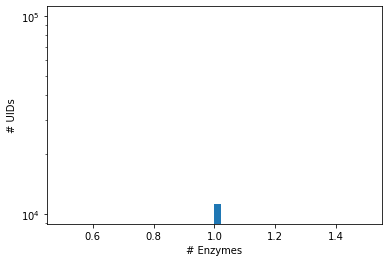

In [35]:
import matplotlib.pyplot as pl
pl.hist([len(v) for v in flatDB.values()], bins = 50)
pl.xlabel('# Enzymes')
pl.ylabel('# UIDs')
pl.yscale('log')
pl.show()

##### Free the intermediate dictionaries to free up memory

In [36]:
del(recs)
del(cleanrecs)

In [ ]:
#Done till here

### Find the number of records in the nr.gz database(~1.5h)

In [2]:
from Bio import SeqIO
import gzip
from tqdm import tqdm


fasta_file = '/Users/varundeepakgudhe/Downloads/Dr.Rafael_prev_res_notebooks/Database/nr.gz'


record_count = 0

with gzip.open(fasta_file, 'rt') as handle:
    for record in tqdm(SeqIO.parse(handle, 'fasta'), desc='Counting Records'):
        record_count += 1

print("Total number of records:", record_count)


Counting Records: 595907626it [1:33:16, 106473.27it/s]

Total number of records: 595907626


### b. Parse nr.gz entry by entry, identify seqs corresponding to GIs we want to keep, and write each desired seq to a fasta file with the corresponding query term(s) with a custom header (~3h)

In [23]:
nrgs = '/Users/varundeepakgudhe/Downloads/Dr.Rafael_prev_res_notebooks/Database/nr.gz'
parsedEnzymeRoot = Path('Lietal_FetchedSeqs/parsed_fastas')

#### Dictionaries
# accessionDict
# flatDB->Enzyme(s)

with gzip.open(nrgs, 'rt') as handle:
    for record in tqdm(SeqIO.parse(handle, 'fasta'), total = 595907626, desc = 'Matching Seqs'):
        # '\x01' invisible delimiter
        splitHeaders = record.description.split('\x01')
        acc_org = []
        for entry in splitHeaders:
            acc = entry.split(' ')[0]
            m = re.search('\[.*?\]$', entry)
            if m:
                organism = m.group()[1:-1]
            else:
                organism = 'Missing'
            acc_org.append([acc, organism])
            
        for a, org in acc_org:
            if a in accessionDict.keys():
               # print(type(accessionDict[a]))
                gi = str(abs(accessionDict[a]))
              #  print(gi)
              #  break
                try:
                    for enzyme in [e[10:] for e in flatDB[gi]]:
                        r = copy.copy(record)
                        r.id = '{}|{}|{}|{}'.format(a, gi, enzyme, org)
                        r.name = ''
                        r.description = ''
                        outFastaPath = parsedEnzymeRoot.joinpath(Path('{}.fa'.format(enzyme.replace(' ', '_').replace('/', '__'))))
                        with open(outFastaPath, 'a+') as h:
                            SeqIO.write([r], h, 'fasta')
                except:
                    pass
            else:
                pass

Matching Seqs: 100%|████████| 595907626/595907626 [10:09:28<00:00, 16295.52it/s]


### c. Characterize the written files to check how the parsing went
    - How many files were written?
    - How many sequences do each file have in them?
    - What's the distribution of the lengths of sequences in each file?
    - What fraction of sequences in each file have a missing organism or organism without a species identifier?

In [25]:
names_sizes = []
for path in tqdm(parsedEnzymeRoot.iterdir()):
    if path.is_file():
        recs = [record for record in SeqIO.parse(path, 'fasta')]
        lens = [len(s) for s in recs]
        unique_organisms = set([r.description.split('|')[-1] for r in recs if 'Missing' not in r.description])

        names_sizes.append({'Name': Path(path).stem, 
                            'File_Size': Path(path).stat().st_size,
                            'Num_Seqs': len(recs),
                            'Mean_Len': np.mean(lens),
                            'Std_Len': np.std(lens),
                            'Num_Unique_Organisms': len(unique_organisms)
                           })

names_sizes_df = pd.DataFrame(names_sizes)

2it [00:00, 67.93it/s]


In [26]:
names_sizes_df.sort_values('Num_Unique_Organisms', ascending = False)

,Name,File_Size,Num_Seqs,Mean_Len,Std_Len,Num_Unique_Organisms
0,steroid_DELTA-isomerase,549790,2288,162.284528,85.424643,752


In [ ]:
import matplotlib.pyplot as pl

names_sizes_df.Num_Unique_Organisms.hist(bins = np.logspace(np.log10(0.1),np.log10(10**6), 25))
pl.xscale('log')
pl.xlim(0.1, 10**6)
pl.show()

names_sizes_df.Num_Unique_Organisms.hist(bins = np.logspace(np.log10(0.1),np.log10(10**6), 25), cumulative = True, normed=True)
pl.xscale('log')
pl.xlim(0.1, 10**6)
pl.show()

names_sizes_df.Num_Unique_Organisms.hist(bins = 10)
pl.xlim(0, 10**5)
pl.yscale('log')
pl.show()

print('{} total enzymes'.format(len(names_sizes_df)))
print('{} enzymes with 0 parseable organisms'.format(len(names_sizes_df.loc[names_sizes_df.Num_Unique_Organisms == 0])))
print('{} enzymes with 1–50 parseable organisms'.format(len(names_sizes_df.loc[(names_sizes_df.Num_Unique_Organisms >= 1) & (names_sizes_df.Num_Unique_Organisms < 50)])))
print('{} enzymes with 50–200 parseable organisms'.format(len(names_sizes_df.loc[(names_sizes_df.Num_Unique_Organisms >= 50) & (names_sizes_df.Num_Unique_Organisms < 200)])))
print('{} enzymes with 200–1000 parseable organisms'.format(len(names_sizes_df.loc[(names_sizes_df.Num_Unique_Organisms >= 200) & (names_sizes_df.Num_Unique_Organisms < 1000)])))
print('{} enzymes with 1000—5000 parseable organisms'.format(len(names_sizes_df.loc[(names_sizes_df.Num_Unique_Organisms >= 1000) & (names_sizes_df.Num_Unique_Organisms < 5000)])))
print('{} enzymes with >5000 parseable organisms'.format(len(names_sizes_df.loc[(names_sizes_df.Num_Unique_Organisms >= 5000)])))

## 6. Generate a cleaned copy of the fastas with seqs of organisms in our final bacterial tree only, and seqs consisting of only canonical residues, in the proper *Genus species* form (remove sub-species information)
    - Remove sequences corresponding to organisms that do not appear in the culled tree
    - Remove sequences containing non-standard residues
    - Clean the fasta headers such that the organism header is solely 'Genus species'

### a. Import the list of organisms from the final bacterial tree. This is our "reference" set

In [3]:
from Bio import Phylo

treeRoot = Path('/Users/varundeepakgudhe/Downloads/Dr.Rafael_prev_res_notebooks/Tree_Generation/Processed_Trees/Final_BacterialTrees')
tree = Phylo.read(treeRoot.joinpath('bac120_r86.2_dedup_droppedTipsRenamed_genusSpecies_nonCollapsed.phyloxml'), 'phyloxml')
treeOrganisms = {t.name for t in tree.get_terminals()}

print('The tree has {} organisms'.format(len(treeOrganisms)))

The tree has 5852 organisms


### b. Our allowed amino acids

In [4]:
#from Bio.Alphabet.IUPAC import IUPACProtein

PROT_LETTERS = {'E', 'C', 'N', 'R', 'A', 'M', 'P', 'H', 'D', 'V', 'I', 'Y', 'K', 'F', 'W', 'T', 'G', 'Q', 'L', 'S'}
print('Protein Alphabet: {}'.format(PROT_LETTERS))

Protein Alphabet: {'R', 'Q', 'L', 'N', 'F', 'K', 'C', 'W', 'M', 'E', 'H', 'T', 'I', 'Y', 'D', 'G', 'P', 'V', 'A', 'S'}


### c. Execute the cleaning (~45 min)

In [6]:
oldRoot = Path('Lietal_FetchedSeqs/parsed_fastas/')

newRoot = Path('Lietal_FetchedSeqs/parsed_fastas_cleaned')


cleaning_summary = []
for oldFile in tqdm(oldRoot.iterdir()):
    if oldFile.is_file():
        newFile = newRoot.joinpath(oldFile.name)
        culledCount = 0
        retainedCount = 0
        escapingCondition = 0
        escapees = []
        with open(newFile, 'a+') as nf:
            for record in SeqIO.parse(oldFile, 'fasta'):
                organism = record.description.split('|')[-1]
                orglist = organism.split(' ')
               # print(orglist)
                # Want to short circuit with non-costly crit first to save time
                if organism == 'Missing': #No organism
                    culledCount+=1
                   # print("HEYY missing")
                    pass
                elif len(orglist) == 1: #Catched genus but no species
                    culledCount+=1
               #     print("HEYY orglist")
                    pass
                elif not all([l in PROT_LETTERS for l in set(str(record.seq))]):
                    culledCount+=1
                  #  print("HEYY letters")
                    pass # Check that only IUPAC residues in the sequence
                elif ' '.join(orglist[0:2]) in treeOrganisms:
                    r = copy.copy(record)
                    r.id = '|'.join([*record.description.split('|')[0:3], ' '.join(orglist[0:2])])
                    r.name = ''
                    r.description = ''
                    SeqIO.write(r, nf, 'fasta')
                    retainedCount+=1
                  #  print("HEYY write")
                else: # These should just be recs of organisms not in the retained list
                    escapees.append(record)
                    culledCount+=1
                    escapingCondition+=1
                 #   print("HEYY escapes")
                    pass
        try: 
            esccount = pd.Series([' '.join(r[0:2]) in treeOrganisms for r in escapees]).value_counts().loc[True] 
        except:
            esccount = 0 

        cleaning_summary.append({'Enzyme': oldFile.stem, 'Culled': culledCount, 'Retained': retainedCount, 'EscapingConditions': escapingCondition, 'Escapees_In_Tree': esccount})
        # Note that 'Escapees_In_Tree' should all be 0. If they're not, we need to figure out why and catch that condition
        # Also note that 'Enzyme' is the file handle, so EnzymeName.replace(' ', '_').replace('/', '__')

cleaning_summary_df = pd.DataFrame(cleaning_summary)
display(cleaning_summary_df.head())

2it [00:00, 17.21it/s]


,Enzyme,Culled,Retained,EscapingConditions,Escapees_In_Tree
0,steroid_DELTA-isomerase,815,1473,811,0


### d. Sanity checks—absolutely essential
1. Do all of the uncaught condition records in **c.** correspond to sequences with organisms not in the tree?
2. Do the number of fastas match the number of non-zero counts of expected UIDs (approximately)?
    - nr.gz parsing will generate a *new* fasta only if at least one instance of that enzyme's GIs exists in it
    - Thus, we expect the number of total enzymes with ≥1 UID to *exceed* the number of enzyme fastas written from parsing nr.gz since some "singletons" won't be either mapped to accessions or found in the frozen nr.gz database. This should be only a small fraction of all the enzymes though, and should only apply to enzymes with low returned UID counts
3. Do the number of Culled + Retained closely match (they won't perfectly due to imperfect mapping) the UID count fetched originally? It's important to consider the DEREPLICATED UID count, since UIDs would be fetched only once (They are dereplicated in **4.**).  This is a good general check...

##### Good news: the escaping seqs weren't in the tree, as expected

In [7]:
# 1.
cleaning_summary_df.Escapees_In_Tree.value_counts()

0    1
Name: Escapees_In_Tree, dtype: int64

##### Parse the UID list again to generate a record (~10min)

In [8]:
uid_recs = []
outrecpath = 'Lietal_FetchedSeqs/1912_Lietal_UIDLists.txt'

with open(outrecpath, 'r') as reader:
    l = reader.readline()
    while l:
        splitrec = l.split('\t')
        recuids = ast.literal_eval(splitrec[-1])
        derep_recuids = set(recuids)
        name = splitrec[0]
        count = splitrec[1]
        uid_recs.append({'Enzyme': name, 'Expected_Count': int(count),'Raw_UID_Count': len(recuids), 'Derep_UID_Count': len(derep_recuids)})
        l = reader.readline()

uid_rec_df = pd.DataFrame(uid_recs)

In [9]:
uid_rec_df['Enzyme'] = uid_rec_df.Enzyme.str.replace(' ', '_').str.replace('/', '__')
uid_rec_df.sort_values('Expected_Count', ascending = False, inplace = True)
uid_rec_df.set_index('Enzyme', inplace = True)
display(uid_rec_df.head())

# Another little sanity check. We really did fetch every single UID expected from every query.
print('Number of missing UIDs -> Enzymes')
(uid_rec_df.Expected_Count - uid_rec_df.Raw_UID_Count).value_counts()

,Expected_Count,Raw_UID_Count,Derep_UID_Count
Enzyme,,,
steroid_DELTA-isomerase,11974,11974,11200


Number of missing UIDs -> Enzymes


0    1
dtype: int64

In [10]:
uid_rec_df.sum()

Expected_Count     11974
Raw_UID_Count      11974
Derep_UID_Count    11200
dtype: int64

#### NOTE: Again, we expect Derep_UID_Count to EXCEED the number of UIDs actually present in our GI->Enzyme mapper because there are redundancies in GI *across enzymes* not accounted for here. About 5,000,000 (<10%) in fact.
    - The plots show that we collected almost every sequence for every single enzyme. 
    - We were only truly missing 76471 sequences, or ~0.1% of all sequences.

,Expected_Count,Raw_UID_Count,Derep_UID_Count,Culled,Retained,EscapingConditions,Escapees_In_Tree,Total_Seqs_Gathered,Percent_Expected_Gathered,Retained_Percent_ofGathered
Enzyme,,,,,,,,,,
steroid_DELTA-isomerase,11974,11974,11200,815,1473,811,0,2288,20.428571,64.379371


AttributeError: 'Rectangle' object has no property 'normed'

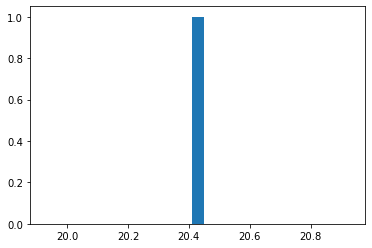

In [11]:
joinedFetchedAndExpected = uid_rec_df.join(cleaning_summary_df.set_index('Enzyme'))
joinedFetchedAndExpected['Total_Seqs_Gathered'] = joinedFetchedAndExpected.Culled + joinedFetchedAndExpected.Retained
joinedFetchedAndExpected['Percent_Expected_Gathered'] = 100*(joinedFetchedAndExpected.Total_Seqs_Gathered)/(joinedFetchedAndExpected.Derep_UID_Count)
joinedFetchedAndExpected['Retained_Percent_ofGathered'] = 100*(joinedFetchedAndExpected.Retained)/(joinedFetchedAndExpected.Total_Seqs_Gathered)

display(joinedFetchedAndExpected.head())
joinedFetchedAndExpected.Percent_Expected_Gathered.hist(bins = 25, normed = True)
pl.ylabel('Percent of Sequences')
pl.xlabel('Percent of Expected Sequences Gathered')
pl.xlim(0, 102)
pl.title('All Enzymes')
pl.show()

joinedFetchedAndExpected.loc[joinedFetchedAndExpected.Derep_UID_Count > 500].Percent_Expected_Gathered.hist(bins = 25, normed = True)
pl.ylabel('Percent of Sequences')
pl.xlabel('Percent of Expected Sequences Gathered')
pl.title('Enzymes with > 500 seqs expected')
pl.xlim(0, 102)
pl.show()

joinedFetchedAndExpected.loc[joinedFetchedAndExpected.Derep_UID_Count > 5000].Percent_Expected_Gathered.hist(bins = 25, normed = True)
pl.ylabel('Percent of Sequences')
pl.xlabel('Percent of Expected Sequences Gathered')
pl.title('Enzymes with > 5000 seqs expected')
pl.xlim(0, 102)
pl.show()

#### This is how many sequences are truly "unaccounted for" (Presumably they weren't present in nr.gz, since only a couple hundred seqs were not successfully mapped from GI -> Acc).
    - Alternative possibility was that there were malformed fastas or errors in the databases that resulted in "false negatives"

In [12]:
print(int((joinedFetchedAndExpected.Derep_UID_Count*((100-joinedFetchedAndExpected.Percent_Expected_Gathered)/100)).sum()), "Missing")

8912 Missing


#### Write these statistics to a file as a record

In [13]:
joinedFetchedAndExpected.to_csv('Lietal_FetchedSeqs/parsed_fastas_cleaned_stats.csv')

#### Which enzymes had a low percent of expected seqs obtained?

In [14]:
joinedFetchedAndExpected.loc[joinedFetchedAndExpected.Percent_Expected_Gathered < 90].sort_values('Percent_Expected_Gathered').head(50)

,Expected_Count,Raw_UID_Count,Derep_UID_Count,Culled,Retained,EscapingConditions,Escapees_In_Tree,Total_Seqs_Gathered,Percent_Expected_Gathered,Retained_Percent_ofGathered
Enzyme,,,,,,,,,,
steroid_DELTA-isomerase,11974,11974,11200,815,1473,811,0,2288,20.428571,64.379371


In [15]:
joinedFetchedAndExpected.sort_values('Total_Seqs_Gathered', ascending = False)

,Expected_Count,Raw_UID_Count,Derep_UID_Count,Culled,Retained,EscapingConditions,Escapees_In_Tree,Total_Seqs_Gathered,Percent_Expected_Gathered,Retained_Percent_ofGathered
Enzyme,,,,,,,,,,
steroid_DELTA-isomerase,11974,11974,11200,815,1473,811,0,2288,20.428571,64.379371


## 7. Finally, generate a set of with the organismal growth temperatures added
- These fastas have many replicates of the SAME sequence belonging to the same organism and different organisms (up to 75% or more for some!)
    - BUT we can't and shouldn't dereplicates these sequences now as we need to construct a consensus sequence on a per-organism level AFTER we've done the alignment
- And although we restricted our queries to NOT include P. aeruginosa and E. coli, many such sequences got returned
    - But we're not going to worry about filtering them out here, because for the biggest returned sets of seqs, they're not dominating the counts

### a. Grab the Li temped list

In [16]:
liOrgListPath = 'Lietal_OrgTempList/temperature_data_full.tsv'

temped_Li_list = pd.read_csv(liOrgListPath, delimiter = '\t').drop_duplicates()
temped_Li_list['genus_name'] = temped_Li_list.organism.apply(lambda s: s.split('_')[0]).str.capitalize()
temped_Li_list['species_name'] = temped_Li_list.organism.apply(lambda s: s.split('_')[1])
temped_Li_list['genus_species'] = temped_Li_list.genus_name + ' ' + temped_Li_list.species_name

organism_temp_dict = temped_Li_list[['genus_species', 'temperature']].set_index('genus_species').squeeze().to_dict()

### b. Append the organismal growth temperatures from Li et al. to the fasta headers and re-write seqs

In [28]:
oldRoot = Path('Lietal_FetchedSeqs/parsed_fastas_cleaned')

newOut = Path('Lietal_FetchedSeqs/parsed_fastas_cleaned_temped')

for parsingFile in tqdm(oldRoot.iterdir()):
    if parsingFile.is_file() and ".ipynb_checkpoints" not in parsingFile.parts:
        print(parsingFile)
        newFile = newOut.joinpath(parsingFile.name)
        with open(newFile, 'a+') as nf:
            recs = []
            for record in SeqIO.parse(parsingFile, 'fasta'):
                r = copy.copy(record)
                organism = r.description.split('|')[-1]
                r.description = r.description+'|{}'.format(organism_temp_dict[organism])
                recs.append(r)
            SeqIO.write(recs, nf, 'fasta')

2it [00:00, 80.04it/s]

Lietal_FetchedSeqs/parsed_fastas_cleaned/steroid_DELTA-isomerase.fa


### c. Parse the contents of each of these files to figure out how many organisms are represented in each. 
#### **NOTE: we will drop all files with fewer than 20 organisms (< 20) represented here because that will be our threshold for when we perform the logistic regression anyway (all the seqs from a given organism are collapsed into one "consensus" sequence before performing logistic regression)**. 
- We may end up dropping more fastas for other enzymes later (after performing pairwise alignments) because represented organismal seqs don't meet our pairwise alignment thresholds, but this will cut down on computation for intermediate steps.


In [29]:
newOut = Path('Lietal_FetchedSeqs/parsed_fastas_cleaned_temped')

allorg_counts = {}
for parsingFile in tqdm(newOut.iterdir()):
    if parsingFile.is_file() and ".ipynb_checkpoints" not in parsingFile.parts:
        print(parsingFile)
        organisms_counts = {}
        for record in SeqIO.parse(parsingFile, 'fasta'):
            organism = record.description.split('|')[-2]
            if organism in organisms_counts.keys():
                organisms_counts[organism]+=1
            else:
                organisms_counts[organism]=1
        allorg_counts[parsingFile.stem] = organisms_counts

allorg_counts_df = pd.DataFrame(allorg_counts)

2it [00:00, 159.03it/s]

Lietal_FetchedSeqs/parsed_fastas_cleaned_temped/steroid_DELTA-isomerase.fa


In [30]:
allorg_counts_df_T = allorg_counts_df.T
allorg_counts_df_T.to_csv('Lietal_FetchedSeqs/parsed_fastas_cleaned_temped/temped_seqcount_summary.csv')

display(allorg_counts_df_T.head())

,Achromobacter denitrificans,Achromobacter insolitus,Acidovorax delafieldii,Acidovorax soli,Actinomadura madurae,Actinomadura mexicana,Actinomadura meyerae,Aeromonas caviae,Aeromonas dhakensis,Aeromonas enteropelogenes,...,Vibrio owensii,Vibrio parahaemolyticus,Virgibacillus massiliensis,Williamsia marianensis,Williamsia muralis,Xanthomonas arboricola,Yersinia enterocolitica,Yersinia entomophaga,Yersinia frederiksenii,Yersinia mollaretii
steroid_DELTA-isomerase,2,2,1,1,2,1,1,21,8,3,...,1,2,1,3,1,41,6,2,3,1


In [31]:
counts = allorg_counts_df_T.sum(axis = 1).sort_values(ascending = False)

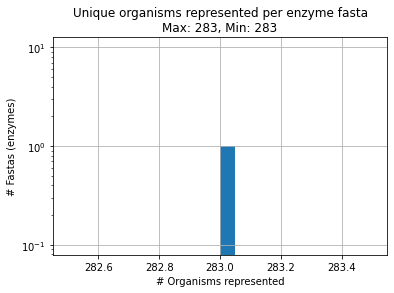

In [32]:
org_counts = pd.Series({k:len(v) for k, v in allorg_counts.items()}, name = 'Num_Unique_Organisms').sort_values(ascending = False)
org_counts.hist(bins = 20)
pl.yscale('log')
pl.xlabel('# Organisms represented')
pl.ylabel('# Fastas (enzymes)')
pl.title('Unique organisms represented per enzyme fasta\nMax: {}, Min: {}'.format(max(org_counts), min(org_counts)));

### d. Perform the file rearrangement to generate a folder of fastas "ready to go" for representative selection

In [33]:
tempedOut = Path('Lietal_FetchedSeqs/parsed_fastas_cleaned_temped')

meetingCritPath = tempedOut.joinpath('MeetingOrgCountCrit/')
failingCritPath = tempedOut.joinpath('FailingOrgCountCrit/')

meetingCritPath.mkdir()
failingCritPath.mkdir()

for enzName, orgcount in tqdm(org_counts.to_dict().items()):
    fileName = enzName+'.fa'
    source = tempedOut.joinpath(fileName)
    if orgcount < 20:
        destination = failingCritPath.joinpath(fileName)
        if not destination.exists():
            source.replace(destination)
    else:
        destination = meetingCritPath.joinpath(fileName)
        if not destination.exists():
            source.replace(destination)

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1855.89it/s]


___

## End State: folder of fastas ready for representative selection and subsequent pairwise alignments